# XGBoost

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset [Link to Dataset](https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original)

In [2]:
dataset = pd.read_csv('Data.csv')
dataset.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
print(f'\nShape of data: {dataset.shape}')
print(dataset.info()) #info about columns, rows and data type, nulls


Shape of data: (683, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB
None


### We first make an exploratory analysis

We'll drop ID(sample code number) as isn't needed for this analysis and remap classes 2/4 to 0/1

In [4]:
dataset.drop(columns=['Sample code number'], inplace=True) # or this optiondf_clean=dataset.iloc[:,1:]

In [5]:
POS = 4
dataset['Class'] = (dataset['Class']==POS).astype(np.int32) 

In [6]:
dataset

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,0
679,2,1,1,1,2,1,1,1,1,0
680,5,10,10,3,7,3,8,10,2,1
681,4,8,6,4,3,4,10,6,1,1


In [7]:
print(f'\nstatistical basics: \n{dataset.describe()}') 


statistical basics: 
       Clump Thickness  Uniformity of Cell Size  Uniformity of Cell Shape  \
count       683.000000               683.000000                683.000000   
mean          4.442167                 3.150805                  3.215227   
std           2.820761                 3.065145                  2.988581   
min           1.000000                 1.000000                  1.000000   
25%           2.000000                 1.000000                  1.000000   
50%           4.000000                 1.000000                  1.000000   
75%           6.000000                 5.000000                  5.000000   
max          10.000000                10.000000                 10.000000   

       Marginal Adhesion  Single Epithelial Cell Size  Bare Nuclei  \
count         683.000000                   683.000000   683.000000   
mean            2.830161                     3.234261     3.544656   
std             2.864562                     2.223085     3.643857   
min 

In [8]:
# split dataframe into two based on class M or B
dfM=dataset[dataset['Class'] ==1] #malign 
dfB=dataset[dataset['Class'] ==0] #benign 

In [9]:
dfM.head(3)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,8,10,10,8,7,10,9,7,1,1
12,5,3,3,3,2,3,4,4,1,1
14,8,7,5,10,7,9,5,5,4,1


In [10]:
features_col=list(dataset.columns[:-1]) #colletcting columns 
print(features_col)

['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']


- Here the hist represents M -> Malign and B -> benign with their mean and median labeled by feature
- the scale 1-10 stands for close to normal-most abnormal

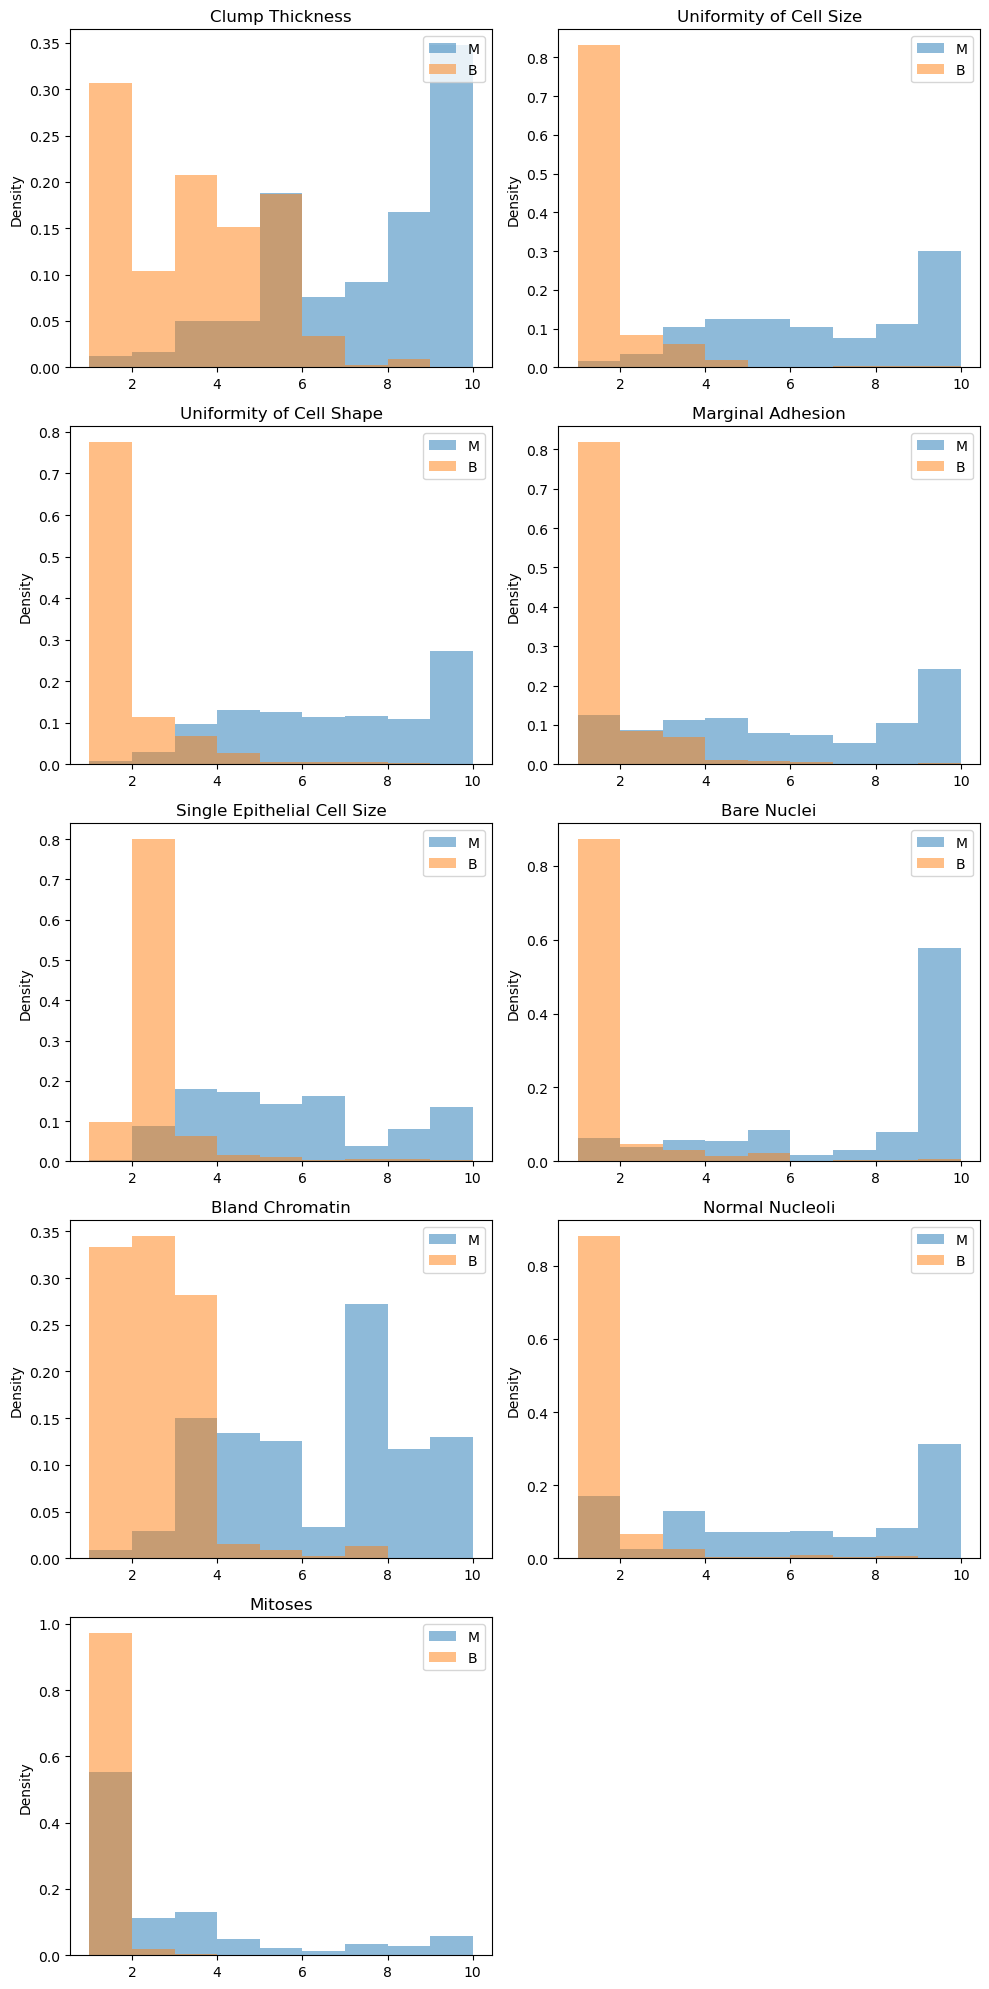

In [11]:
#Stack the data
ncols = 2
nrows = (len(features_col) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4*nrows))
axes = axes.ravel()

for i, col in enumerate(features_col):
    m = dfM[col].dropna().to_numpy()
    b = dfB[col].dropna().to_numpy()

    # Choose ONE of these bin strategies:
    # For continuous features:
    bins = np.histogram_bin_edges(np.r_[m, b], bins='auto')
    # For discrete 1..10 features (UCI original):
    # bins = np.arange(0.5, 10.6, 1)

    ax = axes[i]
    ax.hist(m, bins=bins, density=True, alpha=0.5, label='M')
    ax.hist(b, bins=bins, density=True, alpha=0.5, label='B')
    ax.set_title(col)
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# hide extra cells if grid > features
for ax in axes[len(features_col):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

#
Now let's split in our X features and y targets value

In [12]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [13]:
print(X)

[[ 5  1  1 ...  3  1  1]
 [ 5  4  4 ...  3  2  1]
 [ 3  1  1 ...  3  1  1]
 ...
 [ 5 10 10 ...  8 10  2]
 [ 4  8  6 ... 10  6  1]
 [ 4  8  8 ... 10  4  1]]


In [14]:
y

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

In [15]:
print(X.shape)
print(y.shape)

(683, 9)
(683,)


## Splitting the dataset into the Training set and Test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Training XGBoost on the Training set

In [18]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,   #maximum depth of a tree 
    min_child_weight=3, 
    subsample=0.8,  #subsample ratio of the training instances, will occur once in every boosting iteration 
    colsample_bytree=0.8,  #subsample ratio of columns when constructing each tree, once for every tree constructed
    eval_metric='auc'
    #random_state=42
)
classifier.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False #or true if you want to see the processes
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


## Making the Confusion Matrix

Confussion Matrix Values: 
[[85  2]
 [ 1 49]]

Accuracy score: 0.9781021897810219

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        87
           1       0.96      0.98      0.97        50

    accuracy                           0.98       137
   macro avg       0.97      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137



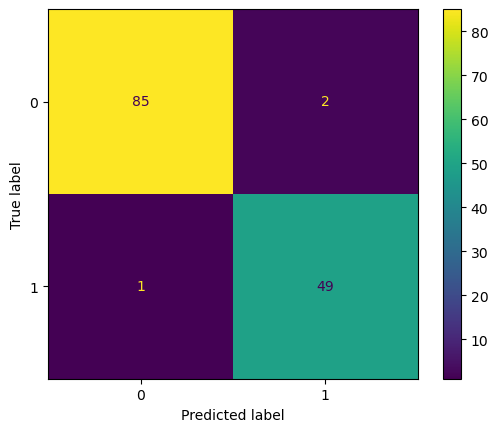

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, accuracy_score, ConfusionMatrixDisplay, classification_report
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f"Confussion Matrix Values: \n{cm}")
print(f"\nAccuracy score: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show()

## Applying k-Fold Cross Validation

In [30]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 97.25 %
Standard Deviation: 1.88 %


## Using GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



np.random.seed(42)
classifier = XGBClassifier(random_state=42)
parameters = {
    #Tree and structure
    'n_estimators': np.random.randint(100, 1000, 3),           
    'max_depth': np.random.randint(3, 10, 3),                  
    'min_child_weight': np.random.randint(1, 10, 3),            
    
    # learning and sampling
    'learning_rate': np.round(np.random.uniform(0.01, 1.0, 4), 3), 
    'subsample': np.round(np.random.uniform(0.4, 0.9, 3), 2),        
    'colsample_bytree': np.round(np.random.uniform(0.4, 0.9, 3), 2), 
    
    #You can add regularization if it's needed
    
    #Others
    'eval_metric': ['auc']
}

grid_search = GridSearchCV(estimator = classifier,  #Using same clasifier SVC
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=1, #this show us a basic progress of the method
                           n_jobs = -1)  #-1 is for using all nucleos available

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
#Number of combinations(we need to see how much computational cost will take)
n_combinations = (len(parameters['n_estimators']) * 
                  len(parameters['max_depth']) * 
                  len(parameters['min_child_weight']) * 
                  len(parameters['learning_rate']) * 
                  len(parameters['subsample']) * 
                  len(parameters['colsample_bytree']))

print(f"\nNúmero total de combinaciones: {n_combinations}")
print(f"Entrenamientos con 5-fold CV: {n_combinations * 5}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Accuracy: 97.62 %
Best Parameters: {'colsample_bytree': np.float64(0.4), 'eval_metric': 'auc', 'learning_rate': np.float64(0.465), 'max_depth': np.int32(9), 'min_child_weight': np.int32(7), 'n_estimators': np.int32(202), 'subsample': np.float64(0.76)}

Número total de combinaciones: 972
Entrenamientos con 5-fold CV: 4860


## Using RandomizedSearchCV

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np


classifier = XGBClassifier(random_state=42)

param_distributions = {
    # Tree and structure
    'n_estimators': randint(500, 1000),
    'max_depth': randint(6, 10),
    'min_child_weight': randint(1, 10),
    
    # Learning and sampling  
    'learning_rate': uniform(0.01, 0.1),  
    'subsample': uniform(0.6, 0.4),    #is not [a,b] x, but [loc=a, scale=b-a] ---> [0.4, 0.4+0.6=1]     
    'colsample_bytree': uniform(0.6, 0.4), 
    
    # Others
    'eval_metric': ['auc']
}

random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_distributions,
    n_iter=500,           # <- number of random combinations to test
    scoring='accuracy',
    cv=10,
    verbose=2,          
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_accuracy = random_search.best_score_
best_parameters = random_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best Accuracy: 97.26 %
Best Parameters: {'colsample_bytree': np.float64(0.9119502183430496), 'eval_metric': 'auc', 'learning_rate': np.float64(0.07420316461542878), 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 955, 'subsample': np.float64(0.9141362604455774)}


Confussion Matrix Values: 
[[84  3]
 [ 2 48]]

Accuracy score: 0.9635 (96.35%)

Best parameters from RandomizedSearchCV: {'colsample_bytree': np.float64(0.9119502183430496), 'eval_metric': 'auc', 'learning_rate': np.float64(0.07420316461542878), 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 955, 'subsample': np.float64(0.9141362604455774)}
Best cross-validation accuracy: 0.9726 (97.26%)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        87
           1       0.94      0.96      0.95        50

    accuracy                           0.96       137
   macro avg       0.96      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137



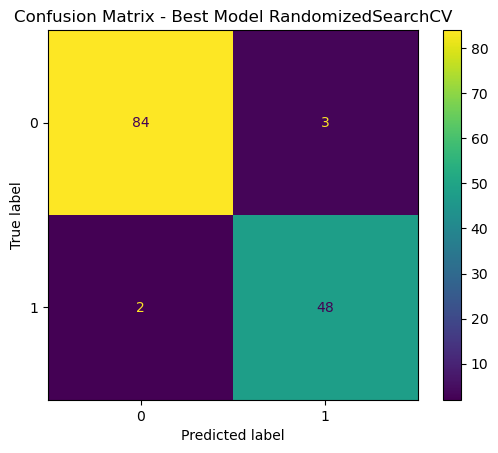

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
#graphics 

y_pred = best_model.predict(X_test)  # ← Cambio importante aquí

# Calcular métricas
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Confussion Matrix Values: \n{cm}")
print(f"\nAccuracy score: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nBest parameters from RandomizedSearchCV: {best_parameters}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f} ({best_accuracy*100:.2f}%)")
print("\n" + "="*50)
print("Classification Report:")
print(classification_report(y_test, y_pred))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Best Model RandomizedSearchCV")
plt.show()

- As we tried to improve our model with RandomSearchCV, GridSearchCV we could say that our first model configuration was slightly better 
- It is better to adjust the threshold to increase the FP because it's better to have more people thinking they need further tests rather than thinking they're completely healthy (FN) when they might not be.

=== Medical Safety-Oriented Classification ===
Strategy: Greater threshold to reduce missed cancer cases
Threshold: 0.7 (default: 0.5)
Confusion Matrix:
[[84  3]
 [ 2 48]]
False Negatives (Safe): 2
False Positives (Dangerous): 3

               precision    recall  f1-score   support

   Benign (0)       0.98      0.97      0.97        87
Malignant (1)       0.94      0.96      0.95        50

     accuracy                           0.96       137
    macro avg       0.96      0.96      0.96       137
 weighted avg       0.96      0.96      0.96       137



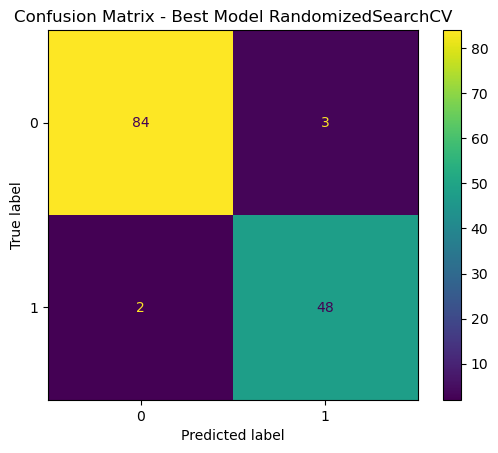

In [57]:
# Get probability scores instead of hard predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Lower threshold to increase False Positives & decrease False Negatives
safety_threshold = 0.7  # Instead of default 0.5
y_pred_safe = (y_pred_proba >= safety_threshold).astype(int)

print("=== Medical Safety-Oriented Classification ===")
print("Strategy: Greater threshold to reduce missed cancer cases")
print(f"Threshold: {safety_threshold} (default: 0.5)")

cm = confusion_matrix(y_test, y_pred_safe)
print(f"Confusion Matrix:\n{cm}")
print(f"False Negatives (Safe): {cm[1,0]}")
print(f"False Positives (Dangerous): {cm[0,1]}")

print("\n" + classification_report(y_test, y_pred_safe, 
                                 target_names=['Benign (0)', 'Malignant (1)']))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_safe)
plt.title("Confusion Matrix - Best Model RandomizedSearchCV")
plt.show()